# Alternation score vs. learning strength

In [3]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sys
sys.path.append('../..')
from data_import import*
from helper import*
from scipy.stats import zscore
import copy
from plot_params import*
from paths import*

pp = PlotParams()
paths = paths()

In [5]:
f4_path = paths.f4_path+ 'NOGTHSH/'
figsave_loc = paths.plot_save_path + 'D10/'

In [6]:
def corr_computation(data):
    corr_matrix = (data
                           .groupby(['model', 'participant', 'e_train', 'e_test', 'day'])
                           [['rt','rt_predicted']]
                           .corr())

    corr_matrix.reset_index(inplace = True)
    corr_matrix.drop(['level_5', 'rt'], axis = 1, inplace = True)
    matrix = corr_matrix.loc[corr_matrix['rt_predicted'] !=1]
    matrix['r_sqr'] = matrix.rt_predicted**2
    matrix.drop('rt_predicted', axis = 1, inplace = True)
    data = matrix.set_index(['model', 'participant', 'e_test'])
    return (data)

In [8]:
data = import_and_transform_data(f4_path, 'NOGTHSH_LEARNING_CURVES_d10_NOG_218_225_4chain_23_09_14.csv')
data_tag, data = data

In [9]:
data_with_cutoff = corr_computation(drop_RTs_above_3std_below_180(data))

In [11]:
## Reorganise the data
zigzag_score = data_with_cutoff.loc['iHMM']
zigzag_score = zigzag_score.reset_index().set_index(['day', 'participant', 'e_test'])
zigzag_score = zigzag_score.unstack(0).drop('e_train', axis = 1)
zigzag_score.columns = ['day_8_model', 'day_9_model']

In [12]:
## Remove the shared variance, centering the data
zigzag_score['avg_r_sqr'] =  zigzag_score[['day_8_model', 'day_9_model']].mean(axis = 1)
zigzag_score['day_8_cent'] = zigzag_score['day_8_model'] - zigzag_score['avg_r_sqr']
zigzag_score['day_9_cent'] = zigzag_score['day_9_model'] - zigzag_score['avg_r_sqr']

## Compute an alternation score

The goal is to compute an alternation score, which helps to compare "zigzaging" between participants. 

To get the alternation score, I substract the non-corrsponding models' z-score from the corresponding models z-score. This means for blocks 227_230 and 237_240 CT_D8-CT_D9, and for 232_235 and 242_245 CT_D9-CT_D8.

In [13]:
zigzag_score.reset_index(inplace=True)
zigzag_score.loc[zigzag_score['e_test'].isin(['227_230', '237_240']), 'zigzagscore'] = zigzag_score['day_8_cent'] - zigzag_score['day_9_cent']
zigzag_score.loc[zigzag_score['e_test'].isin(['232_235', '242_245']), 'zigzagscore'] = zigzag_score['day_9_cent'] - zigzag_score['day_8_cent']

print(zigzag_score[['zigzagscore']].min())
print(zigzag_score[['zigzagscore']].max())

zigzagscore   -0.19615
dtype: float64
zigzagscore    0.338366
dtype: float64


In [14]:
zigzag_score.set_index(['participant', 'e_test'], inplace=True)
zigzag_score.reset_index(inplace=True)
zigzag_score = zigzag_score[['participant', 'zigzagscore']].groupby('participant').sum()

## ALTERNTION SCORE VS. LEARNING STRENGTH

In [15]:
LS = pd.read_csv(paths.local_data +'/LS_mean_D5_D8_recalc.csv')
LS.rename(columns={'LS_mean_d5_d8': 'LS'}, inplace=True)
LS.participant = LS.participant.astype('int')
LS.set_index('participant', inplace = True)
LS.head()

LS_zigzag = pd.merge(LS, zigzag_score, left_index=True, right_index=True)

r=0.473, p=0.017*


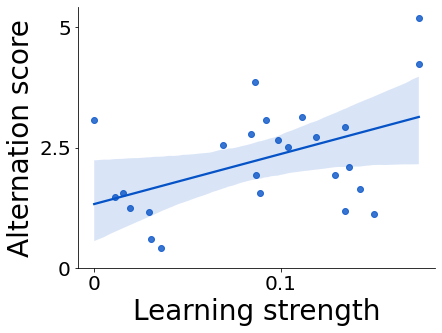

In [16]:
fig, axs = plt.subplots(1, 1, figsize = pp.figsize, facecolor = 'white')
sns_plot = sns.regplot(data = LS_zigzag, x = 'LS', y = 'zigzagscore', color = pp.basic_color)

r, p = sp.stats.pearsonr(x=LS_zigzag.LS, y=LS_zigzag.zigzagscore)

ticklabel_fontsize = pp.ticklabsize
axlabel_fontsize = pp.axlabsize


### Axes, ax labels 
sns_plot.set_ylabel("Alternation score", fontsize = axlabel_fontsize)
sns_plot.set_yticks([0, 0.25, 0.5])
sns_plot.set_yticklabels([0, 2.5, 5], fontsize = ticklabel_fontsize)
sns_plot.set_xlabel("Learning strength", fontsize = axlabel_fontsize)
sns_plot.set_xticks([0, 0.1])
sns_plot.set_xticklabels([0, 0.1], fontsize = ticklabel_fontsize)


sns_plot.spines.right.set_visible(False)
sns_plot.spines.top.set_visible(False)

print ('r={:.3f}, p={:.3f}{}'.format(r, p, get_stars(p)))

In [17]:
fig.savefig(paths.plot_save_path +'/manuscript_plots_standard/' +'zigzag_score.pdf', bbox_inches='tight')
fig.savefig(paths.plot_save_path +'/manuscript_plots_standard/' +'zigzag_score.png', bbox_inches='tight')